In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Add, Activation, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load datasets
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'

In [4]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  print(df)
  df = df[::-1] # Reverse the order
  print(df)
  df.fillna(method='ffill', inplace=True)
  print(df)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  print(df)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  print(df)
  return df

In [5]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    print(df)
    df = df[::-1]  # Reverse the order
    print(df)
    df.fillna(method='ffill', inplace=True)
    print(df)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    print(df)
    return df

In [6]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

print(bitcoin_df)
print(nasdaq_df)
print(usd_df)

            Date      Price       Open       High        Low    Vol. Change %
0     01/06/2024  67,760.80  67,533.90  67,861.00  67,449.60  19.01K    0.34%
1     31/05/2024  67,530.10  68,352.30  69,018.20  66,676.80  61.51K   -1.21%
2     30/05/2024  68,354.70  67,631.30  69,504.70  67,138.40  66.84K    1.06%
3     29/05/2024  67,635.80  68,366.20  68,897.60  67,143.20  52.13K   -1.07%
4     28/05/2024  68,366.00  69,428.30  69,560.70  67,299.90  71.39K   -1.53%
...          ...        ...        ...        ...        ...     ...      ...
4106  05/03/2013       40.3       36.2       40.7       36.2  85.43K   11.56%
4107  04/03/2013       36.2       34.5       36.7       34.2  46.77K    4.78%
4108  03/03/2013       34.5       34.3       34.5       33.8  12.53K    0.73%
4109  02/03/2013       34.3       34.5       34.8       33.2  36.66K   -0.72%
4110  01/03/2013       34.5       33.4       34.9       32.9  39.79K    3.36%

[4111 rows x 7 columns]
            Date      Price       Open 

# DATASET BITCOIN

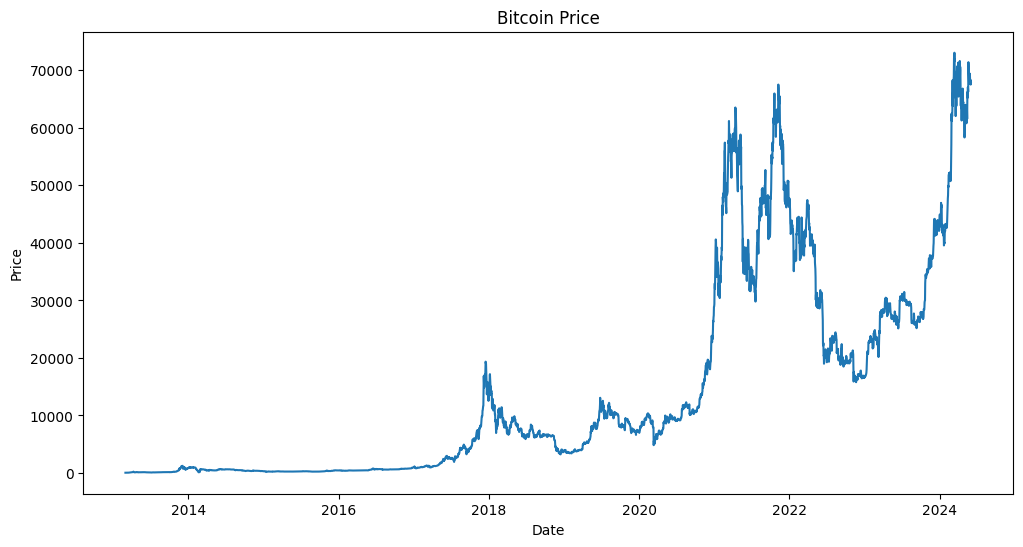

In [7]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


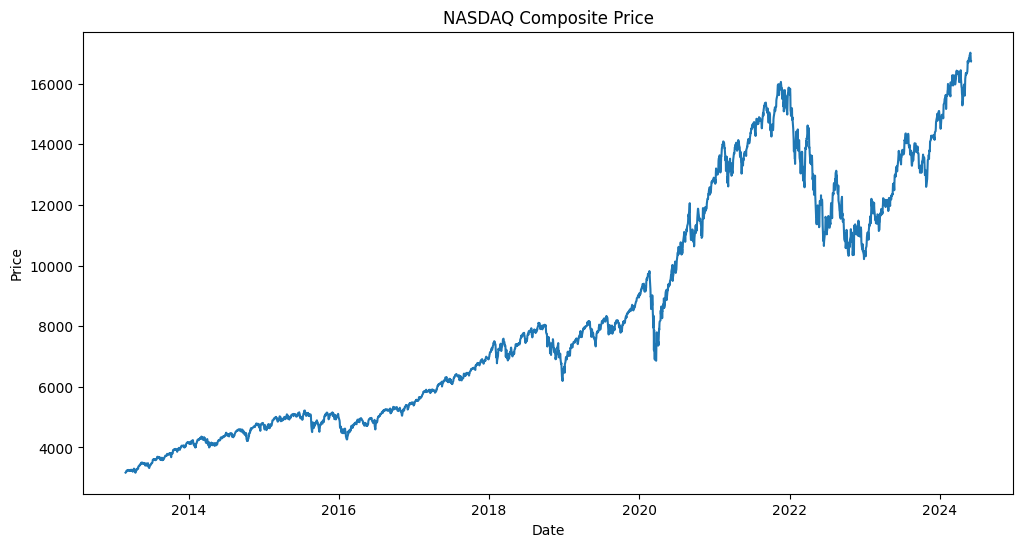

In [8]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

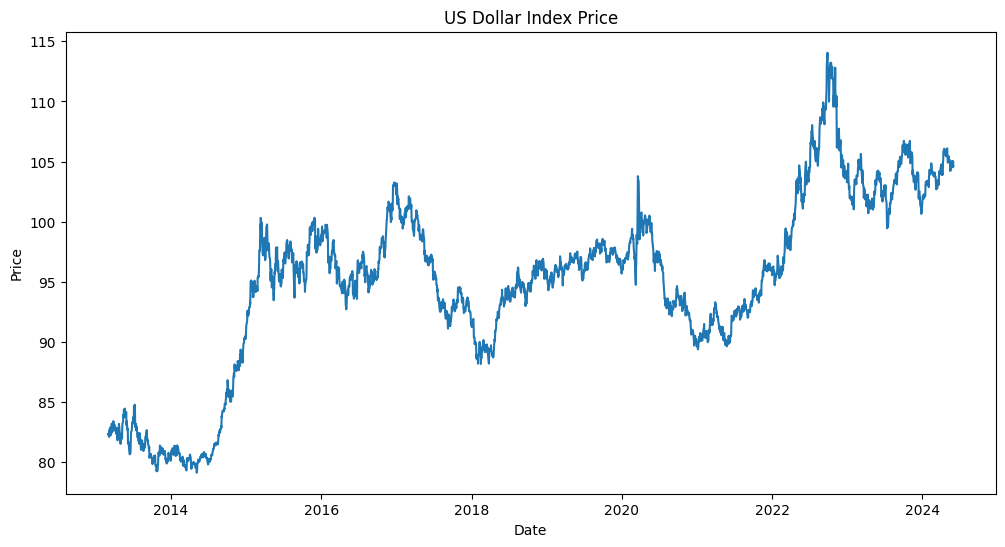

In [9]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [10]:
# Define a function to create sequences and perform forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length][0]  # Predicting 'Price'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
def rolling_forecast_future(model, data, steps, scaler, window_size=30):
    forecast = []
    last_sequence = data[-window_size:]
    print(last_sequence)

    for _ in range(steps // window_size):
        predictions = []
        print(predictions)

        for _ in range(window_size):
            prediction = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
            print(prediction)
            predictions.append(prediction[0][0])
            print(prediction)
            last_sequence = np.roll(last_sequence, -1, axis=0)
            print(last_sequence)
            last_sequence[-1, 0] = prediction[0][0]
            print(last_sequence)

        forecast.extend(predictions)

    forecast = np.array(forecast)
    print(forecast)
    forecast_with_features = np.zeros((forecast.shape[0], data.shape[1]))
    print(forecast_with_features)
    forecast_with_features[:, 0] = forecast  # Fill in the 'Price' predictions
    print(forecast_with_features)

    forecast_with_features = scaler.inverse_transform(forecast_with_features)
    print(forecast_with_features)
    forecast_prices = forecast_with_features[:, 0]  # Extract the 'Price' column
    print(forecast_prices)

    return forecast_prices

In [12]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    print(train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    print(X_train)
    y_train, y_test = y[:train_size], y[train_size:]
    print(y_train)
    return X_train, X_test, y_train, y_test

In [13]:
def build_res_cnn_block(input_layer):
    conv1 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='linear')(conv2)
    skip_connection = Add()([conv1, conv2])
    skip_connection = Activation('relu')(skip_connection)
    return skip_connection

In [14]:
def build_rescnn_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    res_cnn_block1 = build_res_cnn_block(input_layer)
    res_cnn_block2 = build_res_cnn_block(res_cnn_block1)
    lstm_layer = LSTM(64, return_sequences=False)(res_cnn_block2)
    dense1 = Dense(32, activation='relu')(lstm_layer)
    output_layer = Dense(1, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [15]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    print(history)
    predicted_prices = model.predict(X_test).flatten()
    print(predicted_prices)
    mae = mean_absolute_error(y_test, predicted_prices)
    print(mae)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
    print(rmse)
    mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
    print(mape)
    return predicted_prices, mae, rmse, mape

In [16]:
def process_dataset(df, dataset_name, split_ratio):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']])

    # Create sequences
    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    # Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rescnn_lstm_model(input_shape)
    predicted_prices, mae, rmse, mape = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100)

    # Inverse transform to get actual prices
    y_test_reshaped = y_test.reshape(-1, 1)
    predicted_prices_reshaped = predicted_prices.reshape(-1, 1)
    actual_prices = scaler.inverse_transform(np.hstack((y_test_reshaped, np.zeros((y_test_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]
    predicted_prices_actual = scaler.inverse_transform(np.hstack((predicted_prices_reshaped, np.zeros((predicted_prices_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    # Rolling forecast future prices
    forecast_30 = rolling_forecast_future(model, scaled_data, 30, scaler)
    forecast_60 = rolling_forecast_future(model, scaled_data, 60, scaler)
    forecast_90 = rolling_forecast_future(model, scaled_data, 90, scaler)

    forecast_dates_30 = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')
    forecast_dates_60 = pd.date_range(start=df['Date'].iloc[-1], periods=60, freq='D')
    forecast_dates_90 = pd.date_range(start=df['Date'].iloc[-1], periods=90, freq='D')

    plt.plot(forecast_dates_30, forecast_30, color='brown', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_60[30:], forecast_60[30:], color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_90[60:], forecast_90[60:], color='red', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'ResCNN {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4


Streaming output truncated to the last 5000 lines.
 [0.95992989]
 [0.9464495 ]
 [0.93029631]
 [0.93812712]
 [0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.51584464]
 [0.4490104 ]
 [0.41024032]
 [0.36368641]
 [0.39962396]
 [0.40025318]
 [0.41895595]
 [0.40784553]
 [0.37827855]
 [0.35125837]
 [0.32808518]
 [0.30935398]
 [0.28856057]
 [0.27584842]
 [0.26280639]
 [0.2540912 ]]
1/1 [==============================] - 0s 34ms/step
[[0.24318096]]
[[0.24318096]]
[[0.9774948 ]
 [0.95992989]
 [0.9464495 ]
 [0.93029631]
 [0.93812712]
 [0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.51584464]
 [0.4490104 ]
 [0.41024032]
 [0.36368641]
 [0.39962396]
 [0.40025318]
 [0.41895595]
 [0.40784553]
 [0.37827855]
 [0.35125837]
 [0.32808518]
 [0.30935398]
 [0.28856057]
 [0.27584842]
 [0.26280639]
 [0.2540912 ]
 [0.9070654 ]]
[[0.9774948 ]
 [0.95992989]
 [0.9464495 ]
 [0.9302963

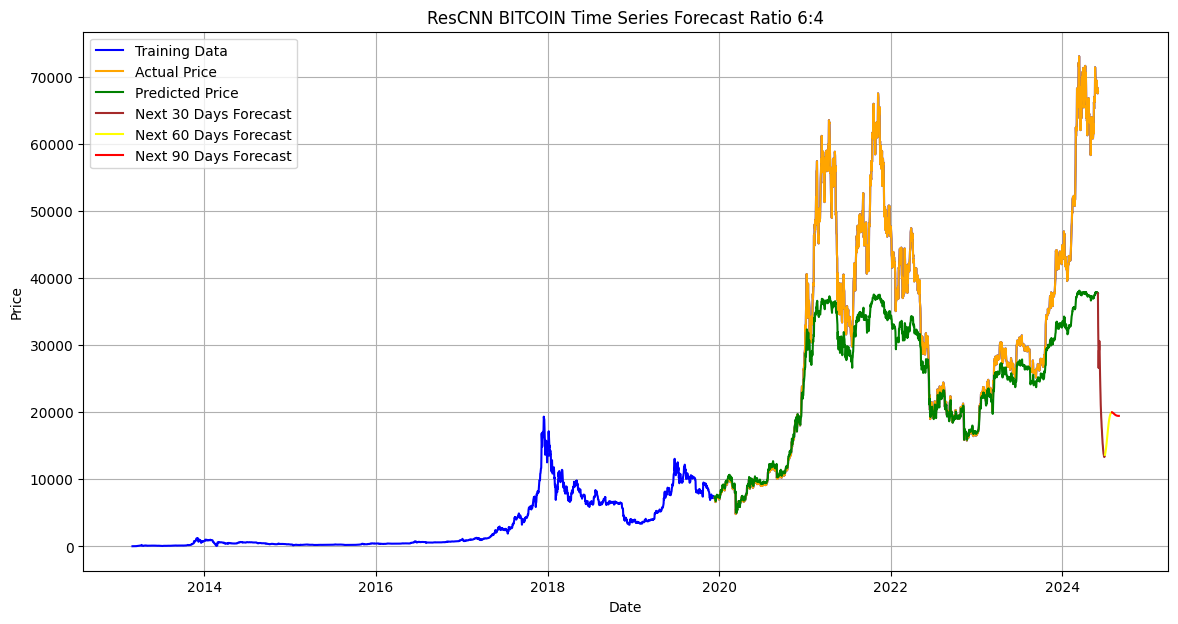

Testing MAE: 0.0927
Testing RMSE: 0.1484
Testing MAPE: 14.68%


In [17]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [ 0.92564218]
 [ 0.93548581]
 [ 0.92419487]
 [ 0.92735376]
 [ 0.65597785]
 [ 0.54542762]
 [ 0.43112916]
 [ 0.3831929 ]
 [ 0.33618656]
 [ 0.27738005]
 [ 0.22607593]
 [ 0.15983821]
 [ 0.08054604]
 [ 0.03847031]
 [ 0.02376246]
 [ 0.00229867]
 [-0.03132778]
 [-0.03235376]
 [-0.03839695]
 [-0.04556001]]
1/1 [==============================] - 0s 36ms/step
[[-0.05602595]]
[[-0.05602595]]
[[ 0.9774948 ]
 [ 0.95992989]
 [ 0.9464495 ]
 [ 0.93029631]
 [ 0.93812712]
 [ 0.94821585]
 [ 0.937678  ]
 [ 0.9501917 ]
 [ 0.93564054]
 [ 0.92564218]
 [ 0.93548581]
 [ 0.92419487]
 [ 0.92735376]
 [ 0.65597785]
 [ 0.54542762]
 [ 0.43112916]
 [ 0.3831929 ]
 [ 0.33618656]
 [ 0.27738005]
 [ 0.22607593]
 [ 0.15983821]
 [ 0.08054604]
 [ 0.03847031]
 [ 0.02376246]
 [ 0.00229867]
 [-0.03132778]
 [-0.03235376]
 [-0.03839695]
 [-0.04556001]
 [ 0.9070654 ]]
[[ 0.9774948 ]
 [ 0.95992989]
 [ 0.9464495 ]
 [ 0.93029631]
 [ 0.93812712]
 [ 0.94821585]
 [ 0.937678  ]
 [ 0.950

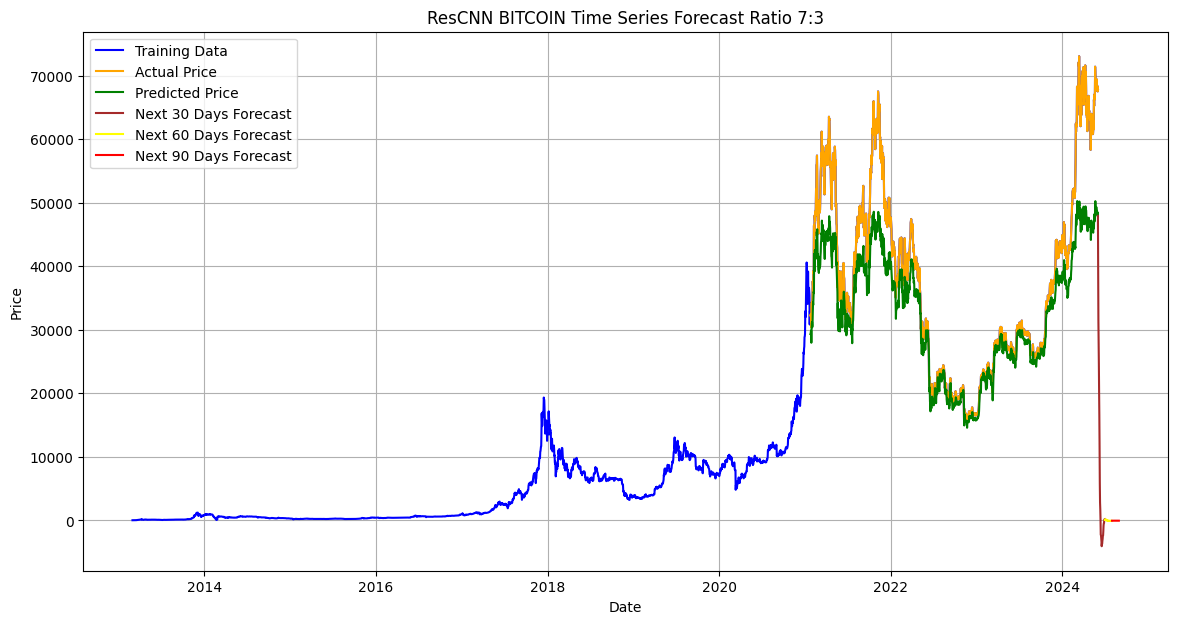

Testing MAE: 0.0720
Testing RMSE: 0.1050
Testing MAPE: 11.08%


In [18]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.9464495 ]
 [0.93029631]
 [0.93812712]
 [0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.93164527]
 [0.93538809]
 [0.93875307]
 [0.941459  ]
 [0.9437905 ]
 [0.9456107 ]
 [0.94695699]
 [0.94798356]
 [0.94881231]
 [0.94944793]
 [0.94992238]
 [0.95030659]
 [0.95060831]
 [0.95086229]
 [0.9510026 ]
 [0.95118296]]
1/1 [==============================] - 0s 32ms/step
[[0.9513657]]
[[0.9513657]]
[[0.9774948 ]
 [0.95992989]
 [0.9464495 ]
 [0.93029631]
 [0.93812712]
 [0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.93164527]
 [0.93538809]
 [0.93875307]
 [0.941459  ]
 [0.9437905 ]
 [0.9456107 ]
 [0.94695699]
 [0.94798356]
 [0.94881231]
 [0.94944793]
 [0.94992238]
 [0.95030659]
 [0.95060831]
 [0.95086229]
 [0.9510026 ]
 [0.95118296]
 [0.9070654 ]]
[[0.9774948 ]
 [0.95992989]
 [0.9464495 ]
 [0.93029631]
 [0.93812712]

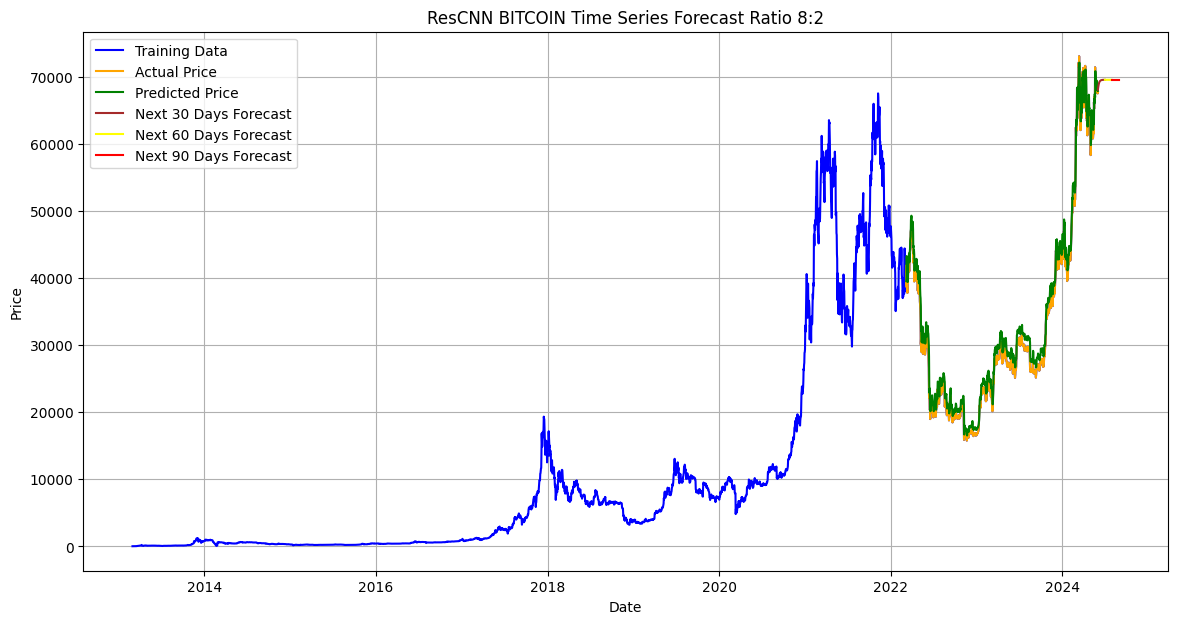

Testing MAE: 0.0195
Testing RMSE: 0.0227
Testing MAPE: 4.83%


In [19]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.97996971]
 [0.97678857]
 [0.9758971 ]
 [0.98375792]
 [0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.88193053]
 [0.81595773]
 [0.75819671]
 [0.71520674]
 [0.68602592]
 [0.66295564]
 [0.64399469]
 [0.62831706]
 [0.61192119]
 [0.5969193 ]
 [0.58311111]
 [0.57036263]
 [0.55615306]
 [0.54355288]
 [0.53153616]
 [0.52121073]]
1/1 [==============================] - 0s 21ms/step
[[0.5101514]]
[[0.5101514]]
[[0.96328009]
 [0.97996971]
 [0.97678857]
 [0.9758971 ]
 [0.98375792]
 [0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.88193053]
 [0.81595773]
 [0.75819671]
 [0.71520674]
 [0.68602592]
 [0.66295564]
 [0.64399469]
 [0.62831706]
 [0.61192119]
 [0.5969193 ]
 [0.58311111]
 [0.57036263]
 [0.55615306]
 [0.54355288]
 [0.53153616]
 [0.52121073]
 [0.95440581]]
[[0.96328009]
 [0.97996971]
 [0.97678857]
 [0.9758971 ]

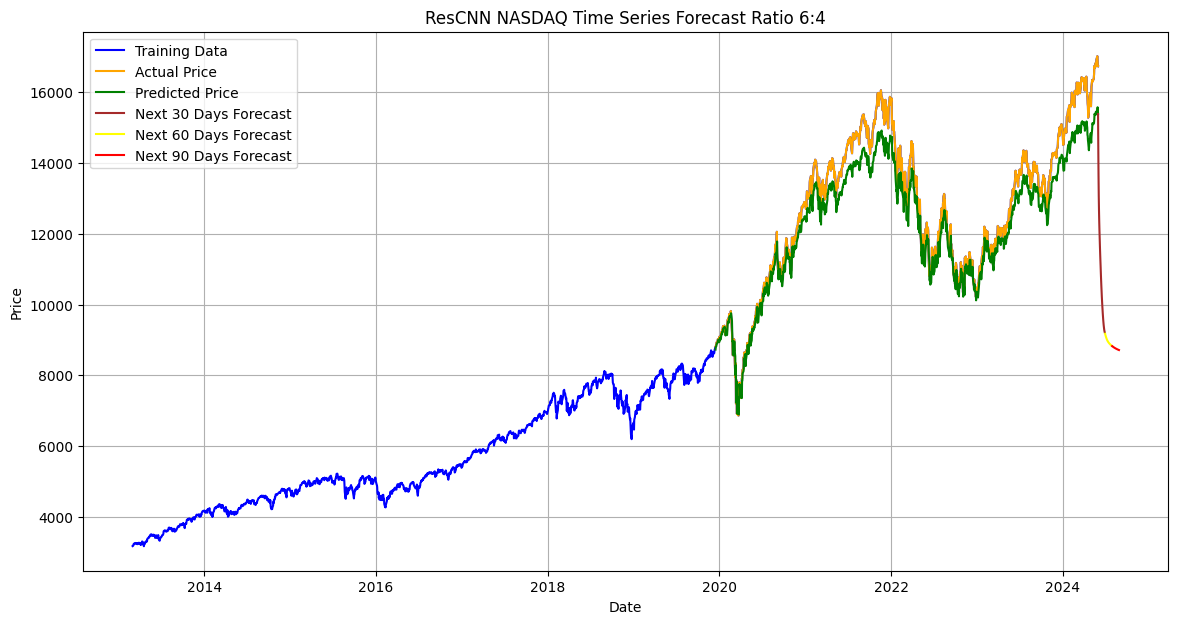

Testing MAE: 0.0361
Testing RMSE: 0.0440
Testing MAPE: 4.81%


In [20]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.97996971]
 [0.97678857]
 [0.9758971 ]
 [0.98375792]
 [0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.95074499]
 [0.93015921]
 [0.9094131 ]
 [0.89210975]
 [0.8784858 ]
 [0.86616445]
 [0.85509455]
 [0.84542072]
 [0.83625638]
 [0.82773328]
 [0.82011527]
 [0.81310844]
 [0.80668616]
 [0.80080169]
 [0.79559112]
 [0.79081041]]
1/1 [==============================] - 0s 22ms/step
[[0.78633666]]
[[0.78633666]]
[[0.96328009]
 [0.97996971]
 [0.97678857]
 [0.9758971 ]
 [0.98375792]
 [0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.95074499]
 [0.93015921]
 [0.9094131 ]
 [0.89210975]
 [0.8784858 ]
 [0.86616445]
 [0.85509455]
 [0.84542072]
 [0.83625638]
 [0.82773328]
 [0.82011527]
 [0.81310844]
 [0.80668616]
 [0.80080169]
 [0.79559112]
 [0.79081041]
 [0.95440581]]
[[0.96328009]
 [0.97996971]
 [0.97678857]
 [0.9758971

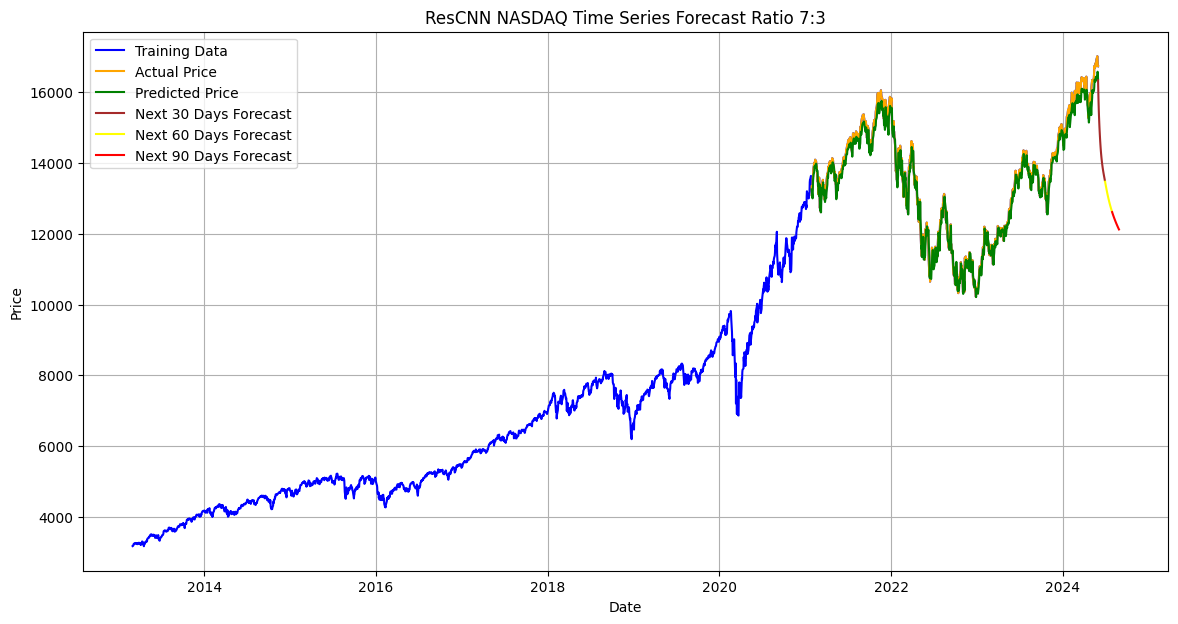

Testing MAE: 0.0138
Testing RMSE: 0.0169
Testing MAPE: 1.83%


In [21]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
[[0.95440581]
 [0.96328009]
 [0.97996971]
 [0.97678857]
 [0.9758971 ]
 [0.98375792]
 [0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [1.00120687]
 [1.02116084]
 [1.03972793]
 [1.05494869]
 [1.0672034 ]
 [1.07770455]
 [1.08733428]
 [1.09578419]
 [1.10306466]
 [1.10940707]
 [1.11537039]
 [1.12035394]
 [1.12483668]
 [1.1288203 ]
 [1.1325841 ]
 [1.13565826]]
1/1 [==============================] - 0s 31ms/step
[[1.1384779]]
[[1.1384779]]
[[0.96328009]
 [0.97996971]
 [0.97678857]
 [0.9758971 ]
 [0.98375792]
 [0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [1.00120687]
 [1.02116084]
 [1.03972793]
 [1.05494869]
 [1.0672034 ]
 [1.07770455]
 [1.08733428]
 [1.09578419]
 [1.10306466]
 [1.10940707]
 [1.11537039]
 [1.12035394]
 [1.12483668]
 [1.1288203 ]
 [1.1325841 ]
 [1.13565826]
 [0.95440581]]
[[0.96328009]
 [0.97996971]

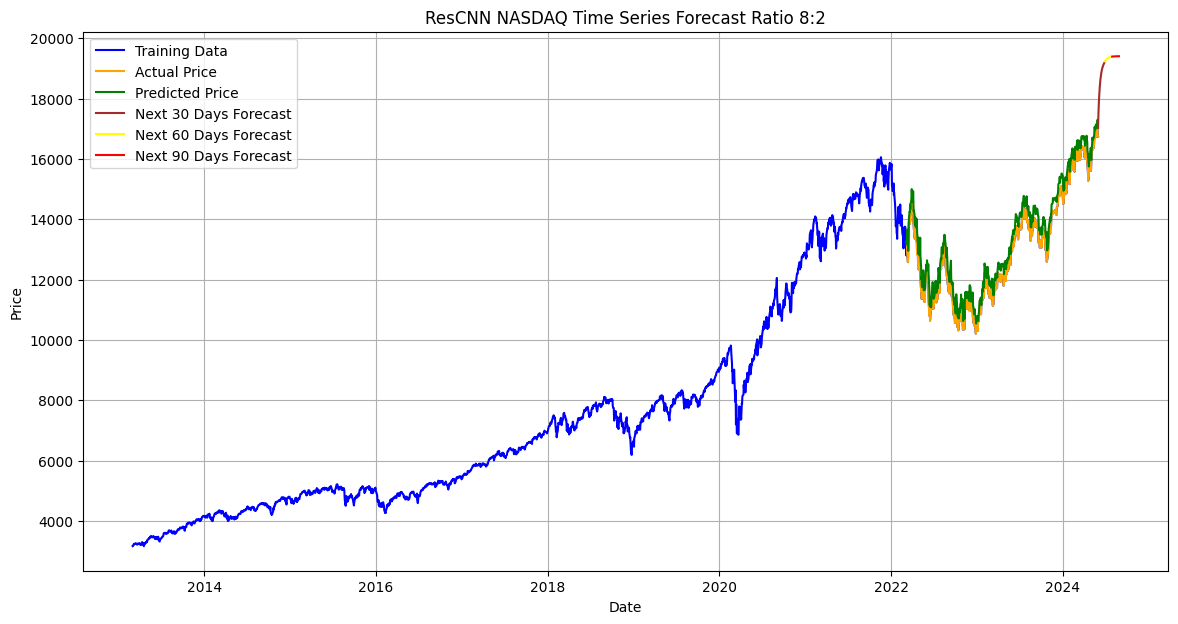

Testing MAE: 0.0266
Testing RMSE: 0.0297
Testing MAPE: 3.82%


In [22]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.60101587]
 [0.59563506]
 [0.74387904]]
[[0.73783683]
 [0.71836431]
 [0.7221729 ]
 [0.72174336]
 [0.72546605]
 [0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.71554023]
 [0.7021172 ]
 [0.68975979]
 [0.67803103]
 [0.6672079 ]
 [0.65733176]
 [0.6481511 ]
 [0.63968688]
 [0.6318984 ]
 [0.62466437]
 [0.61810428]
 [0.61214334]
 [0.60647696]
 [0.60101587]
 [0.59563506]
 [0.59053886]]
1/1 [==============================] - 0s 22ms/step
[[0.5855214]]
[[0.5855214]]
[[0.71836431]
 [0.7221729 ]
 [0.72174336]
 [0.72546605]
 [0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.71554023]
 [0.7021172 ]
 [0.68975979]
 [0.67803103]
 [0.6672079 ]
 [0.65733176]
 [0.6481511 ]
 [0.63968688]
 [0.6318984 ]
 [0.62466437]
 [0.61810428]
 [0.61214334]
 [0.60647696]
 [0.60101587]
 [0.59563506]
 [0.59053886]

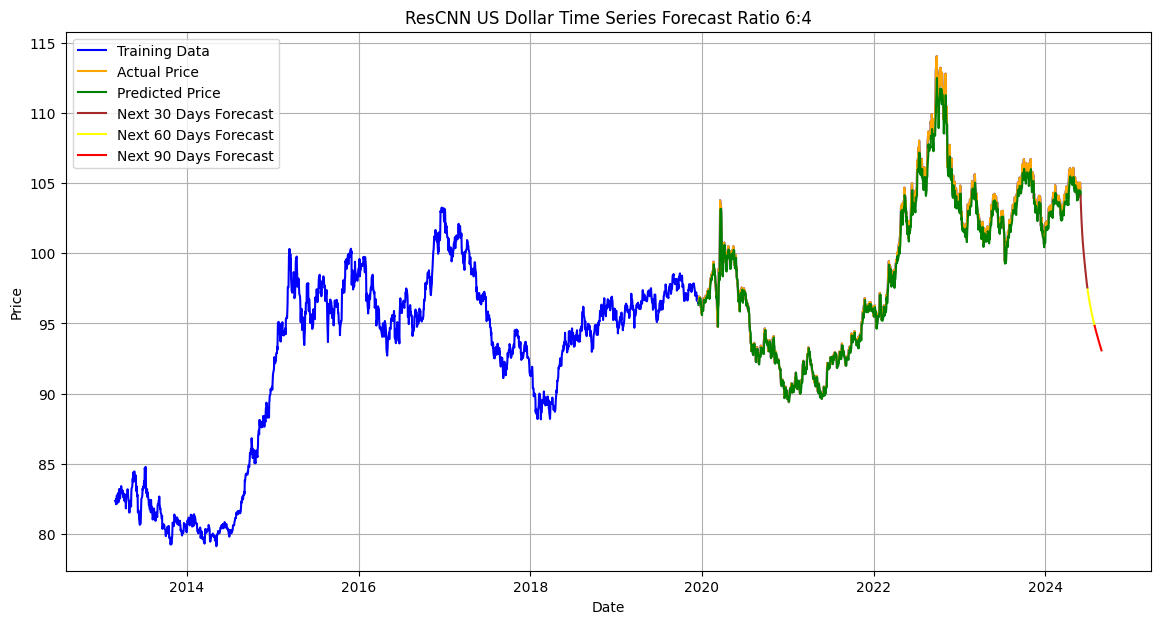

Testing MAE: 0.0130
Testing RMSE: 0.0176
Testing MAPE: 2.14%


In [23]:
results = process_dataset(usd_df, "US Dollar", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.55385727]
 [0.54666543]
 [0.74387904]]
[[0.73783683]
 [0.71836431]
 [0.7221729 ]
 [0.72174336]
 [0.72546605]
 [0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.7085374 ]
 [0.68873221]
 [0.66948605]
 [0.65198773]
 [0.63671607]
 [0.62312472]
 [0.61148041]
 [0.60120469]
 [0.5921123 ]
 [0.5834344 ]
 [0.5753516 ]
 [0.5681172 ]
 [0.56096703]
 [0.55385727]
 [0.54666543]
 [0.53985125]]
1/1 [==============================] - 0s 22ms/step
[[0.53280413]]
[[0.53280413]]
[[0.71836431]
 [0.7221729 ]
 [0.72174336]
 [0.72546605]
 [0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.7085374 ]
 [0.68873221]
 [0.66948605]
 [0.65198773]
 [0.63671607]
 [0.62312472]
 [0.61148041]
 [0.60120469]
 [0.5921123 ]
 [0.5834344 ]
 [0.5753516 ]
 [0.5681172 ]
 [0.56096703]
 [0.55385727]
 [0.54666543]
 [0.5398512

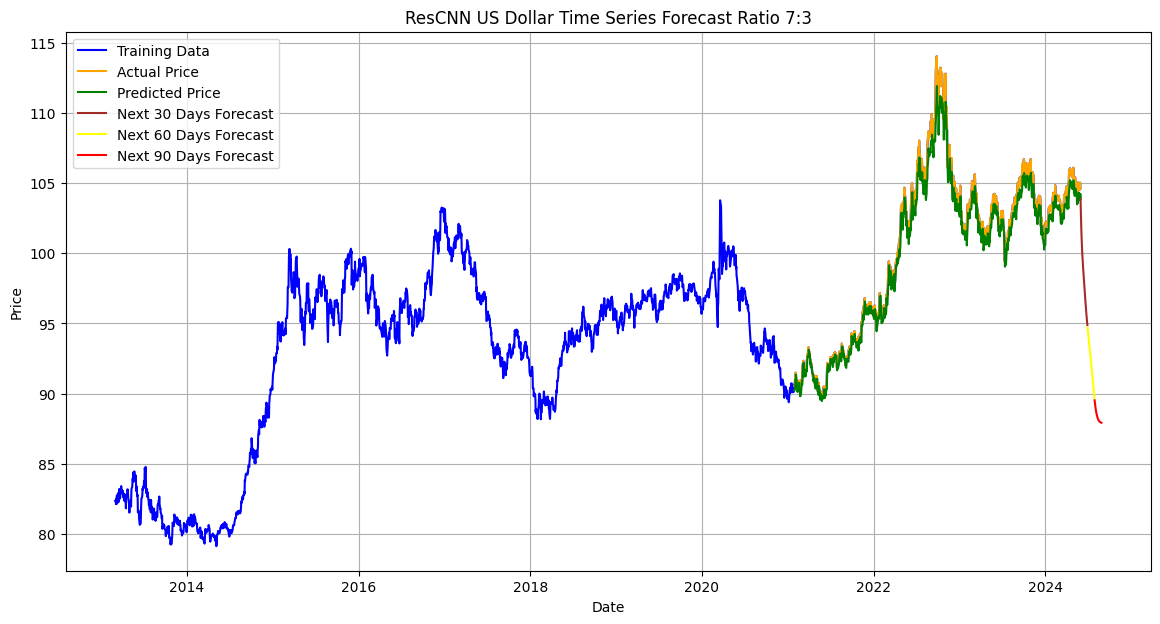

Testing MAE: 0.0185
Testing RMSE: 0.0238
Testing MAPE: 2.84%


In [24]:
results = process_dataset(usd_df, "US Dollar", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.56558532]
 [0.55949789]
 [0.74387904]]
[[0.73783683]
 [0.71836431]
 [0.7221729 ]
 [0.72174336]
 [0.72546605]
 [0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.70732939]
 [0.68773729]
 [0.66993088]
 [0.65422809]
 [0.63997614]
 [0.62794113]
 [0.61732155]
 [0.60789239]
 [0.59950113]
 [0.5917533 ]
 [0.58462298]
 [0.57813597]
 [0.57172948]
 [0.56558532]
 [0.55949789]
 [0.55363154]]
1/1 [==============================] - 0s 22ms/step
[[0.5475064]]
[[0.5475064]]
[[0.71836431]
 [0.7221729 ]
 [0.72174336]
 [0.72546605]
 [0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.70732939]
 [0.68773729]
 [0.66993088]
 [0.65422809]
 [0.63997614]
 [0.62794113]
 [0.61732155]
 [0.60789239]
 [0.59950113]
 [0.5917533 ]
 [0.58462298]
 [0.57813597]
 [0.57172948]
 [0.56558532]
 [0.55949789]
 [0.55363154]

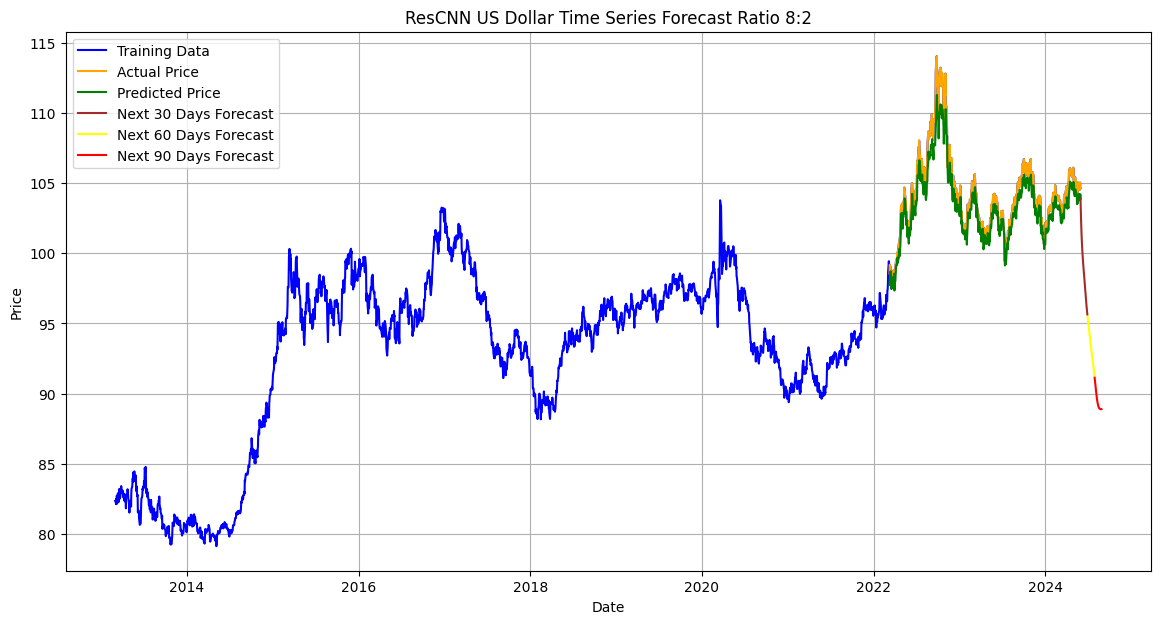

Testing MAE: 0.0246
Testing RMSE: 0.0303
Testing MAPE: 3.28%


In [25]:
results = process_dataset(usd_df, "US Dollar", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')